In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os
from itertools import combinations
from collections import Counter

## Merge .csv files

In [2]:
all_files = [file for file in os.listdir('./Sales_Data')]

dfs = []
for file in all_files:
    dfs.append(pd.read_csv('./Sales_Data/' + file, index_col=None, header=0))

frame = pd.concat(dfs, ignore_index=True)
frame.to_csv("all_sales_data.csv", index=False)

In [3]:
all_data = pd.read_csv("all_sales_data.csv")
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,295665,Macbook Pro Laptop,1,1700,12/30/19 00:01,"136 Church St, New York City, NY 10001"
1,295666,LG Washing Machine,1,600.0,12/29/19 07:03,"562 2nd St, New York City, NY 10001"
2,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001"
3,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016"
4,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301"


## Clean up

In [4]:
clean_up = all_data.loc[all_data['Order ID'] == 'Order ID'].index.to_list()

all_data.drop(all_data.index[clean_up], inplace=True)

all_data.dropna(inplace=True)

#### Convert columns to correct types

In [5]:
all_data['Quantity Ordered'] = all_data['Quantity Ordered'].astype('int32')
all_data['Price Each'] = all_data['Price Each'].astype('float')

## Augment columns

#### Add month column in int

In [6]:
all_data['Month'] = all_data['Order Date'].str.slice(0,2)
all_data['Month'] = all_data['Month'].astype('int32')

#### Add total sales column

In [7]:
 all_data['Total Sales'] = all_data['Quantity Ordered'] * all_data['Price Each']

#### Add a city column

In [8]:
address_split = all_data['Purchase Address'].str.split(",", n=3, expand=True)
all_data['Purchase City'] = address_split[1]
all_data['Purchase State'] = address_split[2].str.split(" ", n=2, expand=True)[1]

## What was the best month for sales?


#### Find month for max total sales

In [9]:
monthly_totals_df = all_data.groupby('Month', as_index=False).sum()
column = monthly_totals_df['Total Sales']
max_total_sales = column.max()

monthly_totals_df.loc[monthly_totals_df['Total Sales'] == max_total_sales]

,Month,Quantity Ordered,Price Each,Total Sales
11,12,28114,4588415.41,4613443.34




#### Monthly Total Sales Bar Graph

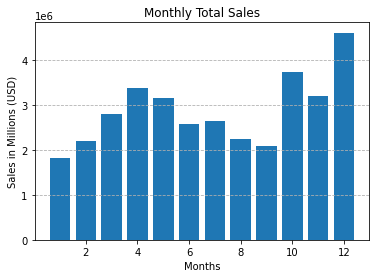

In [10]:
plt.bar(monthly_totals_df['Month'], monthly_totals_df['Total Sales'])

plt.title('Monthly Total Sales')
plt.xlabel('Months')
plt.ylabel('Sales in Millions (USD)')
plt.grid(axis='y', linestyle='--')
plt.show()

## Which locations had the highest amount of sales?

#### Find city for max total sales 

In [11]:
city_totals_df = all_data.groupby(['Purchase City', 'Purchase State'], as_index=False).sum()
column1 = city_totals_df['Total Sales']
max_city_sales = column1.max()

city_totals_df.loc[city_totals_df['Total Sales'] == max_city_sales]

,Purchase City,Purchase State,Quantity Ordered,Price Each,Month,Total Sales
8,San Francisco,CA,50239,8211461.74,315520,8262203.91


#### Total Sales by City Bar Graph

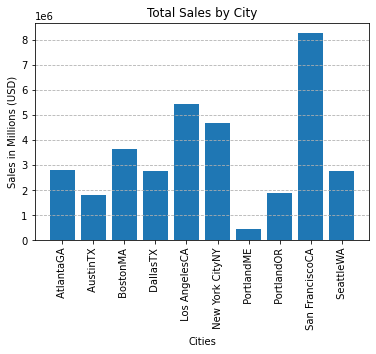

In [12]:
plt.bar(city_totals_df[['Purchase City','Purchase State']].sum(axis=1),city_totals_df['Total Sales'])

plt.title('Total Sales by City')
plt.xlabel('Cities')
plt.ylabel('Sales in Millions (USD)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--')
plt.show()

#### Find state for max sales

In [13]:
state_totals_df = all_data.groupby(['Purchase State'], as_index=False).sum()
column2 = state_totals_df['Total Sales']
max_state_sales = column2.max()

state_totals_df.loc[state_totals_df['Total Sales'] == max_state_sales]

,Purchase State,Quantity Ordered,Price Each,Month,Total Sales
0,CA,83528,13632896.97,523845,13714774.71


#### Total Sales by State

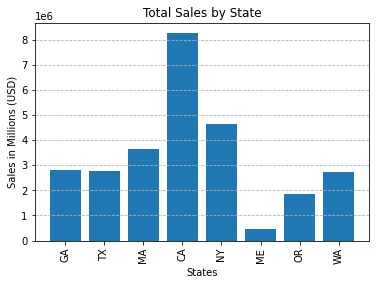

In [14]:
plt.bar(city_totals_df['Purchase State'],city_totals_df['Total Sales'])

plt.title('Total Sales by State')
plt.xlabel('States')
plt.ylabel('Sales in Millions (USD)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--')
plt.show()

## What time should we display advertisements to maximize the likelihood of purchases?

In [15]:
all_data['Order Date'] = all_data['Order Date'].astype("datetime64")

In [16]:
all_data['Order Time'] = all_data['Order Date'].dt.time
sales_dates = all_data['Order Date']

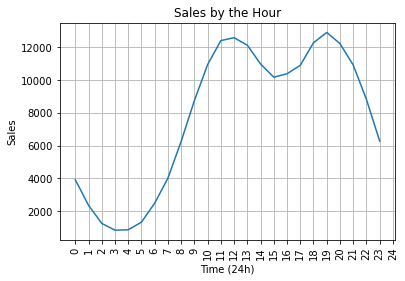

In [17]:
time_ticks = range(25)
sales_dates.groupby(sales_dates.dt.hour).count().plot()
plt.title('Sales by the Hour')
plt.xlabel('Time (24h)')
plt.ylabel('Sales')
plt.xticks(ticks=time_ticks, rotation=90)
plt.grid()
plt.show()

## What products are sold together the most?

In [18]:
duplicated_df = all_data[all_data.duplicated(subset='Order ID',keep=False)]
duplicated_df['Grouped Products'] = duplicated_df.groupby('Order ID')['Product'].transform(lambda x:','.join(x))

/var/folders/80/gznqvszs12d33zlhdfd7y__r0000gn/T/ipykernel_35102/495379243.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicated_df['Grouped Products'] = duplicated_df.groupby('Order ID')['Product'].transform(lambda x:','.join(x))


In [19]:
duplicated_clean = duplicated_df[['Order ID','Grouped Products']].drop_duplicates(subset='Order ID')

In [24]:
count = Counter()

for row in duplicated_df['Grouped Products']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list,2)))

count.most_common(10)

[(('iPhone', 'Lightning Charging Cable'), 2140),
 (('Google Phone', 'USB-C Charging Cable'), 2116),
 (('iPhone', 'Wired Headphones'), 987),
 (('Google Phone', 'Wired Headphones'), 949),
 (('iPhone', 'Apple Airpods Headphones'), 799),
 (('Vareebadd Phone', 'USB-C Charging Cable'), 773),
 (('Google Phone', 'Bose SoundSport Headphones'), 503),
 (('USB-C Charging Cable', 'Wired Headphones'), 452),
 (('Vareebadd Phone', 'Wired Headphones'), 327),
 (('Lightning Charging Cable', 'Wired Headphones'), 253)]